# **Better Edges**

- Stephen Welch
- UNCC Computer Vision

**Required Reading/Viewing:**

1. Placeholder 

Recommended [Jupyter Theme](https://github.com/dunovank/jupyter-themes) for presenting this notebook:
````
jt -t grade3 -cellw=90% -fs=20 -tfs=20 -ofs=20
````

In [1]:
#(Optional) Download data + videos if you don't have them.
import os
from util.get_and_unpack import get_and_unpack

if not os.path.isdir('data/'):
    url = 'http://www.welchlabs.io/unccv/the_original_problem/data/data.zip'
    get_and_unpack(url)
    
if not os.path.isdir('videos/'):
    url = 'http://www.welchlabs.io/unccv/the_original_problem/videos.zip'
    get_and_unpack(url)   

![](graphics/spacer_small.png)

### Problems with our implementation of Robert's Cross from last time

1. **Noisy** - Robert's Cross is quite susceptible to noise.
2. **Anisotropic** - doesn't respond as strongly to slanted edges. 
3. **Slow** as we've implemented it here.
4. **No Direction** as we've implemented Robert's Cross here, we only learn about the **magnitude** of our esimate of the image intensity derivative, not its **direction.** 

Hopefully you've taken some time to think through some possible fixes to these problems. Let's have a look at them one at a time.

## **1. Noisy**

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
#Load image
im = imread('data/medium_2/ball/ball_3.jpg')

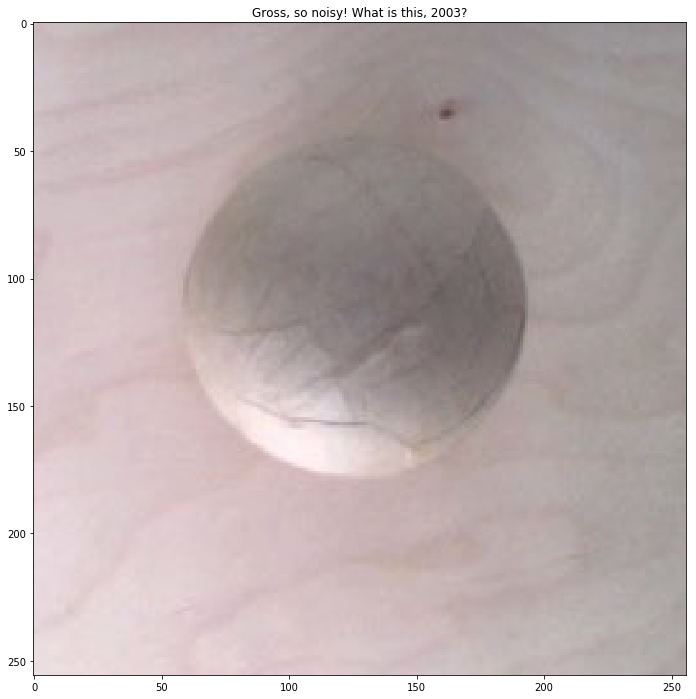

In [4]:
#Let's have a look
fig = figure(0, (12,12))
imshow(im)
title('Gross, so noisy! What is this, 2003?');

- This is a particularly noisy image from our dataset - it was captured under relatively low light conditions with the webcam of my 2008 macbook.
- The z-axis height of the surface below corresponds to the grayscale intesnity of our image.

![](videos/noisy_image_rotating_3.gif)

- Let's have a look at the result of our implementation of Robert's Cross from last time on this image. 
- This is brings us to some important points about how we'll be using python in the couse.

## A little bit about python + the jupyter notebook

- There's a couple of methods from our last notebook that we would like to use here. 
- We could copy + paste these methods into this notebook, but a better appraoch is to create a python module in a seperate .py file that holds commonly used code. 
- You may have noticed the "util" directory in this repo:

In [5]:
ls

README.md                       data/
[1] The Original Problem.ipynb  graphics/
[2] Edges.ipynb                 papers/
[3] Better Edges.ipynb          requirements.txt
__MACOSX/                       util/
challenge/                      videos/


It contains a serveral python modules that contain the various methods we'll develop in the module:

In [6]:
ls util/*

util/filters.py         util/get_and_unpack.py  util/image.py

util/__pycache__:
filters.cpython-36.pyc         image.cpython-36.pyc
get_and_unpack.cpython-36.pyc


- Let's go have a look at one of these .py files in a text editor. 
- We can import specific methods from these .py files like this: 

In [7]:
from util.image import convert_to_grayscale

While we're at it, let's look a few nice notebook features. We can see the docstring of the methods we're using right in the notebook by adding a question mark to the end of method or class names:

In [8]:
convert_to_grayscale?

Another nice feature: Press **Shift+Tab** with your cursor inside a methods parenthesis to see it's arguments. 

![](graphics/spacer_small.png)

![](videos/shift_tab.gif)

![](graphics/spacer_small.png)

And finally, you can access search all commands using the command pallate:
- **(cmnd + shift + p)** on mac
- **(ctrl + shift + p)** on linux/windows

And to view all keyboard shortucts press **esc** then **h.**

![](videos/jupyter_shortcuts.gif)

### **One more thing about importing python modules**

- Modules are compiled on import. 
- If we poke around our util director after import, we see that each python file is compiled into it's own .pyc in a python automatically generated directory called \__pycache__

In [9]:
ls util*

__pycache__/       filters.py         get_and_unpack.py  image.py


In [10]:
ls util/__pycache__/

filters.cpython-36.pyc         image.cpython-36.pyc
get_and_unpack.cpython-36.pyc


- The important thing to note here is that if you make a change to a .py file, the results of this change will not actually show up **until you reimport the module**, recompiling the .py into .pyc.
- Generally, I'll just run "Restart and Run All" from the Kernel dropdown menu when I make a module change. 
- **Quick Demo:**

In [11]:
gray = convert_to_grayscale(im/255.)

![](graphics/spacer_small.png)

![](graphics/spacer_small.png)

### **Ok, enough fun with jupyter - let's process our noisy image.**

In [12]:
gray = convert_to_grayscale(im)

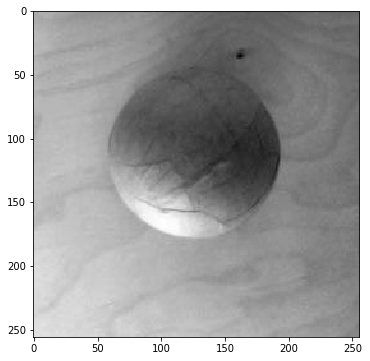

In [13]:
fig = figure(0, (6,6))
imshow(gray, cmap = 'gray');

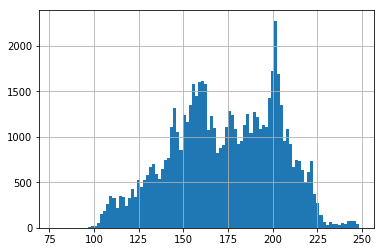

In [14]:
hist(gray.ravel(), 100);
grid(1)

In [15]:
from util.filters import roberts_cross

In [16]:
edges = roberts_cross(gray)

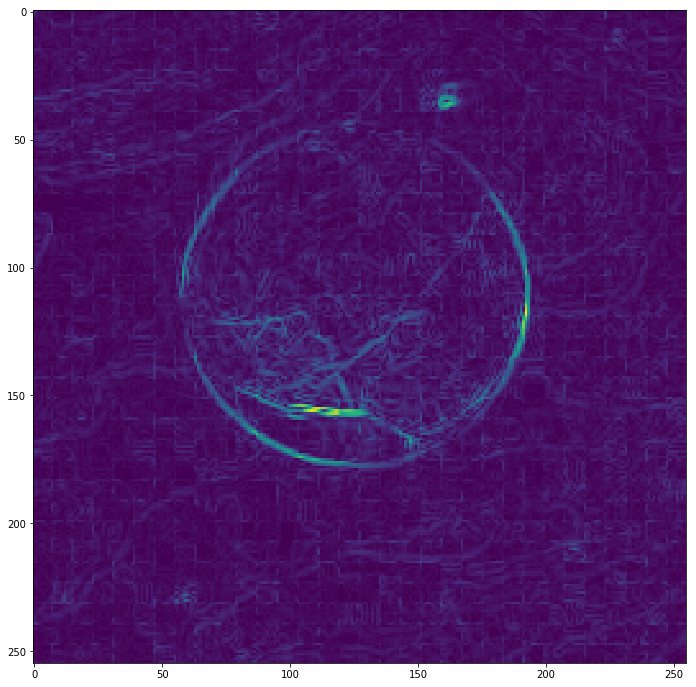

In [17]:
fig = figure(0, (12,12))
imshow(edges);

## Now, how can we remove some of the noise from our image?

- Any ideas?
- Are there properties of our noise that we can exploit to help us seperate it from our signal?

![](videos/noisy_image_rotating_1.gif)

## **Local Averages**

A very successful/popular appraoch to noise reduction is to replace the individual pixels in our images with some type of weighted average of their local neighborhoods.

![](graphics/averaging_slides/01.png)

# **How would this operation change the appearance of our image?**

![](graphics/spacer_small.png)

- Let's find out!
- Now, before we code this up, let's generalize this process a little.
- A more general way to think about the average of our neighborhood is as the dot product of our image patch with a (3x3) matrix.

In [18]:
#Little trick to progress through slides within the notebook
from IPython.display import Image, display
from ipywidgets import interact

#Quick method to let me step through "slides"
def slide_show(slide_num=1):     
    display(Image('graphics/averaging_slides/' + str(slide_num).zfill(2) + '.png'))

In [19]:
interact(slide_show, slide_num = (1, 2));

A Jupyter Widget

- It turns out that taking the dot product of our image patch with a small matrix or kernel like this is incredibly common in computer vision.
- Doing this across a whole image is called filtering, convolution, or cross correlation, we'll get into the details later.
- Let's write a method to filter an image with an arbitray kernel/filter
- First, let's think though how exactly our method will work.

![](graphics/question_three-01.png)

- Now, let's think about how to describe what we would like to do mathematically.
- But first, we need to define the coordinate system we'll use on our images.

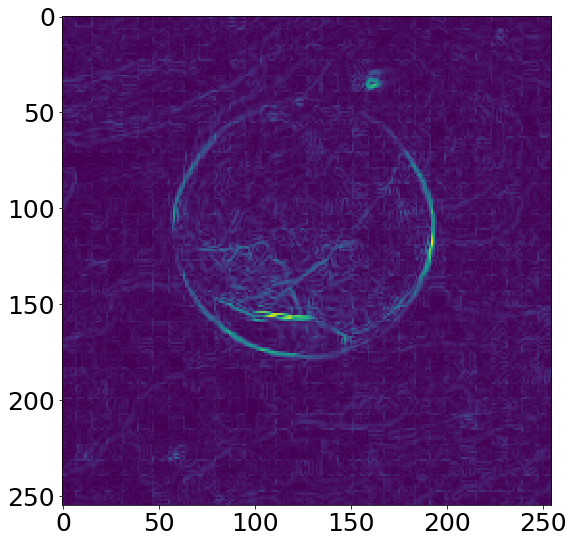

In [32]:
fig = figure(0, (9,9))
ax = fig.add_subplot(111)
ax.imshow(edges)
ax.tick_params(axis='both', which='major', labelsize=25)

- As you may already know, the coordinate system of images in matplotlib is defined with the origin in the upper left hand corner, positive is down and to ther right. Our first index corresponds to the vertical dimension and our second index corresponds to the horizontal.

![](graphics/question_four-01.png)

- For convenience (for now), let's define the the origin of Kernel coordinate systems to be in the center of our Kernel, and let our kernel be of size 2N+1 by 2M+1. This forces our kernel have odd dimensions (as opposed to even), but we can deal with that for now.

![](graphics/spacer_small.png)

![](graphics/spacer_small.png)

# An Equation!

# $$
S(i, j) = \sum_{m=-M}^M \sum_{n=-N}^N I(i+m, j+n)K(m, n)
$$

- Alright, now we're getting somewhere!
- This operation is know as [cross correlation](https://en.wikipedia.org/wiki/Cross-correlation) in 2 dimensions, and is very similar to [convolution](https://en.wikipedia.org/wiki/Convolution), something we'll discuss later. To compute convolution instead of cross correlation, we simply flip our kernel relavive to our images: $S(i, j) = \sum_{m=-M}^M \sum_{n=-N}^N I(i-m, j-n)K(m, n)$.
- Now, we're almost ready to code this up, but first we have one last adjustment to make. 
- Since both our kernel and images are going to be represented as numpy arrays, we need to index them each from the upper right corner:



![](graphics/question_five-01.png)

**SHITFUC**K - the destination indexing is off. CRAP. Ok, gotta figure out a solution and wrap this section up tomorrow. 

Do I just have to adjust the output indices? Or should I go head and pad? Or, is there something else clever I can do?

- Ok, we're *finally* ready to do some filtering!

In [21]:
def filter_2d(im, kernel):
    '''
    Filter an image by taking the dot product of each 
    image neighborhood with the kernel matrix.
    Args:
    im = (H x W) grayscale floating point image
    kernel = (M x N) matrix, smaller than im
    Returns: 
    (H-M+1 x W-N+1) filtered image.
    '''

    M = kernel.shape[0]
    N = kernel.shape[1]
    H = im.shape[0]
    W = im.shape[1]
    
    filtered_image = np.zeros((H-M+1, W-N+1), dtype = 'float64')
    
    for i in range(filtered_image.shape[0]):
        for j in range(filtered_image.shape[1]):
            image_patch = im[i:i+kernel_height, j:j+kernel_width]
            filtered_image[i, j] = np.sum(np.multiply(image_patch, kernel))
            
    return filtered_image